# import functions etc.

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file
path = "/home/mmurakami/crios_backups/ASTE_270/BarentsS_paper/sample_figs/"

# load or create the mask - mymsk

In [5]:
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
mask = mymsk == iB

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)
# mymsk = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
mymsk.shape

364500


(1350, 270)

In [6]:
# load from files written in ID_anomalies_BarentsS
# Load the .npz file
data = np.load('masks.npz')

# Access the saved masks
msk1 = data['msk1']  # mask for heating and freshening
msk2 = data['msk2']  # mask for heating and salting
msk1[msk1 == 0] = np.nan
msk2[msk2 == 0] = np.nan

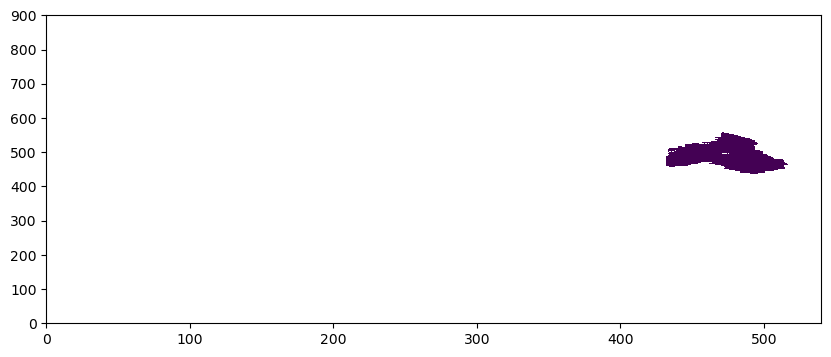

In [7]:
plt.pcolormesh(get_aste_tracer(msk2,nfx,nfy)[0])

In [8]:
mymsk = msk2   # msk1 = Southern section, msk2 = northern section

# run the functions to get J terms

In [9]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',31).copy()
cmaps = plt.get_cmap('rainbow',31).copy()
cmap.set_under(color='white')
cmap_bath = plt.get_cmap('Blues',31).copy()

In [29]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2014"] = np.arange(3,5,1)
print(times)

# times["2013"] = np.arange(1,13,1)
# times["2014"] = np.arange(1,13,1)
# times["2015"] = np.arange(1,13,1)
# times["2016"] = np.arange(1,13,1)
# times["2017"] = np.arange(1,13,1)
# times["2018"] = np.array([1])

# times["2003"] = np.arange(1,13,1)
# times["2004"] = np.arange(1,13,1)
# times["2005"] = np.arange(1,13,1)
# times["2006"] = np.arange(1,13,1)
# times["2007"] = np.arange(1,13,1)
# times["2008"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

{'2014': array([3, 4])}


In [30]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

In [31]:
# dt = datetimes[1]-datetimes[0]   # days
# dt = dt.total_seconds()
# dt

In [32]:
# datetimes
# len(mymsk.shape)

In [33]:
tsteps = len(datetimes)-1
tsteps

1

In [34]:
# set a larger array for one year of the terms
nS,nT = 112,112
vol_mesh_all = np.zeros((tsteps,nS,nT))
JtermsT_all = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all = np.zeros((tsteps,5,nS,nT))

In [35]:
for i in range(len(datetimes)-1):
    print(datetimes[i])
    tsstrhere = tsstr[i:i+2]
    datetimeshere = datetimes[i:i+2]
    dt = datetimes[i+1]-datetimes[i]
    dt = dt.total_seconds()
    t2 = int(tsstr[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,mymsk,iB,RAC,RAC3,myparms)

    vol_mesh_all[i] = vol_mesh
    JtermsT_all[i] = JtermsT
    JtermsS_all[i] = JtermsS
    JtermsT_nn_all[i] = JtermsT_nn
    JtermsS_nn_all[i] = JtermsS_nn

2014-03-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -1.068281313066243e-11 Sv/PSU
doing JtermsS
total residual -0.08102275544163365 Sv/degC
doing not normalized J terms
total residual -1.068281313066243e-11 Sv
total residual -0.08102275544163365 Sv


In [36]:
# reset the mean volume based on the terms
JtermsT = np.nanmean(JtermsT_all,axis=0)
JtermsS = np.nanmean(JtermsS_all,axis=0)
vol_mesh = np.nanmean(vol_mesh_all,axis=0)

JtermsS_nn = np.nanmean(JtermsS_nn_all,axis=0)
JtermsT_nn = np.nanmean(JtermsT_nn_all,axis=0)

In [37]:
JtermsS_nn_all.shape

(1, 5, 112, 112)

# try to do the plotting to see if this worked

In [38]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [39]:
# # read theta and salt averages from the t2 timestep (average)
# file_name = "state_3d_set1"
# meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
# fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
# varnames = np.array(["THETA","SALT"])
# recs = np.array([])
# for var in varnames:
#     irec = np.where(fldlist == var)
#     recs = np.append(recs, irec[0][0])
# THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
# SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

# THETA = THETA.reshape(nz,ny,nx)
# SALT = SALT.reshape(nz,ny,nx)

In [40]:
# create the bins of TS data
refined_section = np.linspace(-3,12,93-30)
coarse_section = np.linspace(12,15,21+30,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [41]:
# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


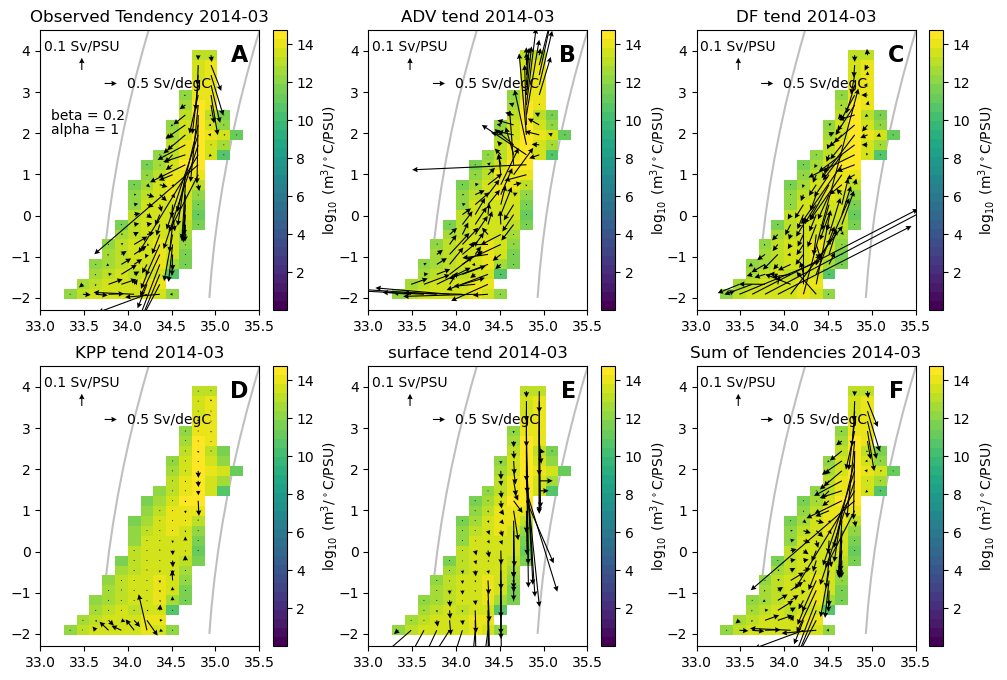

In [42]:
# plot these on a figure to show the budgeted terms
alpha = 1
beta = .2
arrow_length = 0.25     # for the sverdrup arrows
step=1    # for quiver spacing
t = 0
U = .5
scale = 9e0
ypos1 = 0.81  # set the vector position
ypos2 = 0.88  # set the vector position
xpos1 = 0.35
xpos2 = 0.19



# timestr = datetimes[0].strftime("%Y")+ "-" +datetimes[-2].strftime("%Y")
timestr = datetimes[0].strftime("%Y-%m") #+ "-" +datetimes[-1].strftime("%Y")

xlims = np.array([33,35.5])
ylims = np.array([-2.3,4.5])


# first get the values and do conversions to Sv/degC or Sv/PSU
fig = plt.figure(figsize = (12,8))

# total tendency
ax = plt.subplot(231)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Set U1 and V1 and apply alpha and beta scaling
U1, V1 = JtermsS[0], JtermsT[0]
# U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("Observed Tendency " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
# Add alpha and beta text to the plot
ax.text(0.05, 0.62, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
ax.text(0.05, 0.67, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
ax.text(0.95, 0.95, 'A', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# ADV tendency
ax = plt.subplot(232)
U1, V1 = JtermsS[1],JtermsT[1]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("ADV tend " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'B', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05," 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# DF tendency
ax = plt.subplot(233)
U1, V1 = JtermsS[2],JtermsT[2]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("DF tend " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# # ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'C', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# KPP tendency
ax = plt.subplot(234)
U1, V1 = JtermsS[3],JtermsT[3]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("KPP tend " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'D', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# surface tendency
ax = plt.subplot(235)
U1, V1 = JtermsS[4],JtermsT[4]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("surface tend " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'E', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# for total tendency for this square from terms
ax = plt.subplot(236)
U1, V1 = (JtermsS[1] + JtermsS[2] + JtermsS[3] + JtermsS[4]),(JtermsT[1] + JtermsT[2] + JtermsT[3] + JtermsT[4])
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("Sum of Tendencies " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'F', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# save the figure for this point
# plt.savefig(path + "northern_portion_alltend_march2012.png",dpi=300)

# also plot the divergence of terms

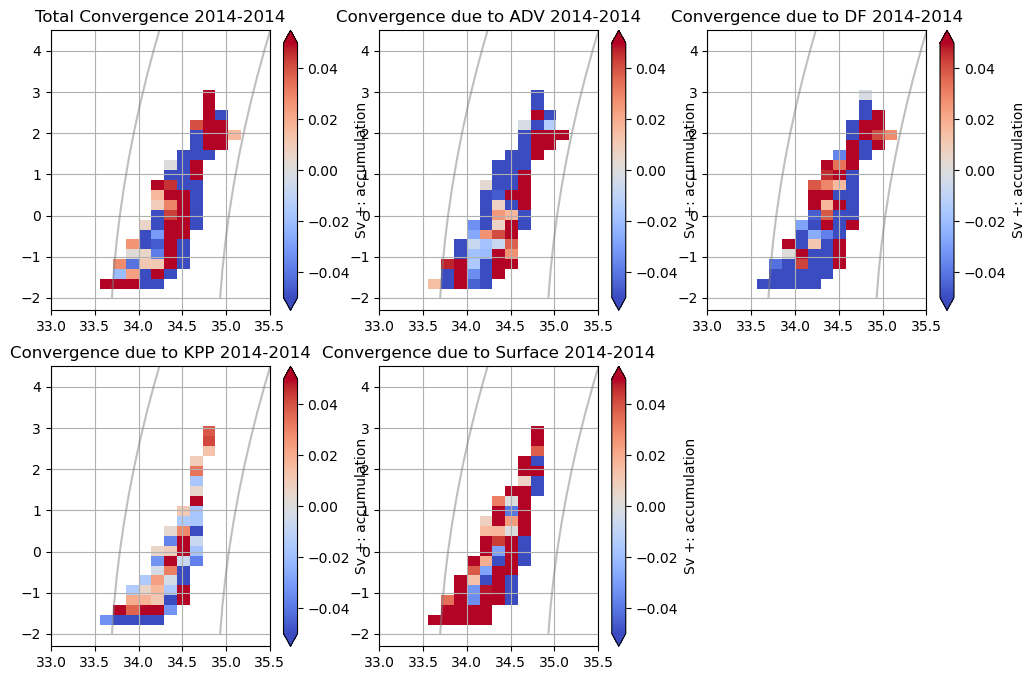

In [43]:
# Calculate the divergence of the vector field (U1, V1)
# Assuming Sbincent and Tbincent are the grid coordinates

vlev = 0.05
# First, set up the plot
fig = plt.figure(figsize=(12, 8))

# Total tendency
ax = plt.subplot(231)
U1, V1 = JtermsS_nn[0], JtermsT_nn[0]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
# U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Set title, limits, and grid
ax.set_title("Total Convergence " + datetimes[0].strftime("%Y")+ "-" +datetimes[-2].strftime("%Y"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()


# Add alpha and beta text to the plot
#ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
#ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################

# advection plot
ax = plt.subplot(232)
U1, V1 = JtermsS_nn[1], JtermsT_nn[1]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
# U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Set title, limits, and grid
ax.set_title("Convergence due to ADV " + datetimes[0].strftime("%Y")+ "-" +datetimes[-2].strftime("%Y"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################
# diffusion plot
ax = plt.subplot(233)
U1, V1 = JtermsS_nn[2], JtermsT_nn[2]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
# U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Convergence due to DF " + datetimes[0].strftime("%Y")+ "-" +datetimes[-2].strftime("%Y"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################
# KPP plot
ax = plt.subplot(234)
U1, V1 = JtermsS_nn[3], JtermsT_nn[3]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
# U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Convergence due to KPP " + datetimes[0].strftime("%Y")+ "-" +datetimes[-2].strftime("%Y"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()


# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################
# surface plot
ax = plt.subplot(235)
U1, V1 = JtermsS_nn[4], JtermsT_nn[4]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
# U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Convergence due to Surface " + datetimes[0].strftime("%Y")+ "-" +datetimes[-2].strftime("%Y"))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# plt.savefig(path + "convergence_NBarents_2013_17.png",dpi=300)

# save this as a field so we can compare with the anomalies

In [28]:
## Syntax below for the 5 years
# JtermsS_03_07 = JtermsS.copy()
# JtermsT_03_07 = JtermsT.copy()
# JtermsS_nn_03_07 = JtermsS_nn.copy()
# JtermsT_nn_03_07 = JtermsT_nn.copy()

## Syntax here for one month
# JtermsS_y1 = JtermsS.copy()
# JtermsT_y1 = JtermsT.copy()

# JtermsS_nn_y1 = JtermsS_nn.copy()
# JtermsT_nn_y1 = JtermsT_nn.copy()

In [27]:
# JtermsS_y1.shape

## anomalies of the J terms as arrows

In [ ]:
# plot these on a figure to show the budgeted terms
alpha = 1
beta = .2
arrow_length = 0.25     # for the sverdrup arrows
step=2    # for quiver spacing
t = 0
U = .5
scale = 2e0
ypos1 = 0.81  # set the vector position
ypos2 = 0.88  # set the vector position
xpos1 = 0.35
xpos2 = 0.19



# timestr = datetimes[0].strftime("%Y")+ "-" +datetimes[-2].strftime("%Y")
timestr = datetimes[0].strftime("%Y") + "-" +datetimes[-1].strftime("%Y")

xlims = np.array([30,35.5])
ylims = np.array([-2.3,13])


# first get the values and do conversions to Sv/degC or Sv/PSU
fig = plt.figure(figsize = (12,8))

# total tendency
ax = plt.subplot(231)
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Set U1 and V1 and apply alpha and beta scaling
U1, V1 = JtermsS[0], JtermsT[0]
# U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
U1, V1 = U1 * alpha, V1 * beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("Observed Tendency " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
# Add alpha and beta text to the plot
ax.text(0.05, 0.62, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
ax.text(0.05, 0.67, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
ax.text(0.95, 0.95, 'A', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")


# ADV tendency
ax = plt.subplot(232)
U1, V1 = JtermsS[1],JtermsT[1]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("ADV tend " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'B', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# DF tendency
ax = plt.subplot(233)
U1, V1 = JtermsS[2],JtermsT[2]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("DF tend " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# # ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'C', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# KPP tendency
ax = plt.subplot(234)
U1, V1 = JtermsS[3],JtermsT[3]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("KPP tend " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'D', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# surface tendency
ax = plt.subplot(235)
U1, V1 = JtermsS[4],JtermsT[4]
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("surface tend " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'E', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# for total tendency for this square from terms
ax = plt.subplot(236)
U1, V1 = (JtermsS[1] + JtermsS[2] + JtermsS[3] + JtermsS[4]),(JtermsT[1] + JtermsT[2] + JtermsT[3] + JtermsT[4])
# U1[U1 == 0],V1[V1 == 0] = np.nan,np.nan
U1, V1 = U1*alpha,V1*beta
cb1 = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01,zorder=2)
# Plot quiver
# fillna before plotting
U1[U1 == 0] = np.nan
V1[V1 == 0] = np.nan
q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005, scale=scale,zorder=3,headwidth=5)
plt.colorbar(cb1, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
# Set title, limits, and grid
ax.set_title("Sum of Tendencies " + timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
# ax.grid()
# Add the quiver key for Sv/PSU
# Adjust X and Y to position the quiver key appropriately on the plot
quiver_length = 1.0  # Set the length of the arrow for the key
ax.quiverkey(q1,X=xpos1,Y=ypos1,U = U,label=str(U*alpha) + " Sv/degC",labelpos='E')
ax.quiverkey(q1, X=xpos2, Y=ypos2, U=U, label=str(U*beta) + " Sv/PSU",angle=90, labelpos='N', coordinates='axes')
ax.text(0.95, 0.95, 'F', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Add alpha and beta text to the plot
# ax.text(0.05, 0.2, f'alpha = {alpha}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# ax.text(0.05, 0.25, f'beta = {beta}', transform=ax.transAxes, fontsize=10, color='black', verticalalignment='bottom')
# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# save the figure for this point
# plt.savefig(path + "northern_portion_alltend_2013_17.png",dpi=300)

## anomalies of the convergence

In [55]:
# fill nan with 0 in the Jterms before we do subtract; this allows us to plot the divergences
JtermsS_nn_y1[np.isnan(JtermsS_nn_y1)] = 0
JtermsT_nn_y1[np.isnan(JtermsT_nn_y1)] = 0
JtermsS_nn[np.isnan(JtermsS_nn)] = 0
JtermsT_nn[np.isnan(JtermsT_nn)] = 0

In [56]:
# reset the variable names here so we can look at them
JtermsS_nn_03_07 = JtermsS_nn_y1.copy()
JtermsT_nn_03_07 = JtermsT_nn_y1.copy()

In [58]:
# set the time string as a title
timestr = "03/14 - 03/12"

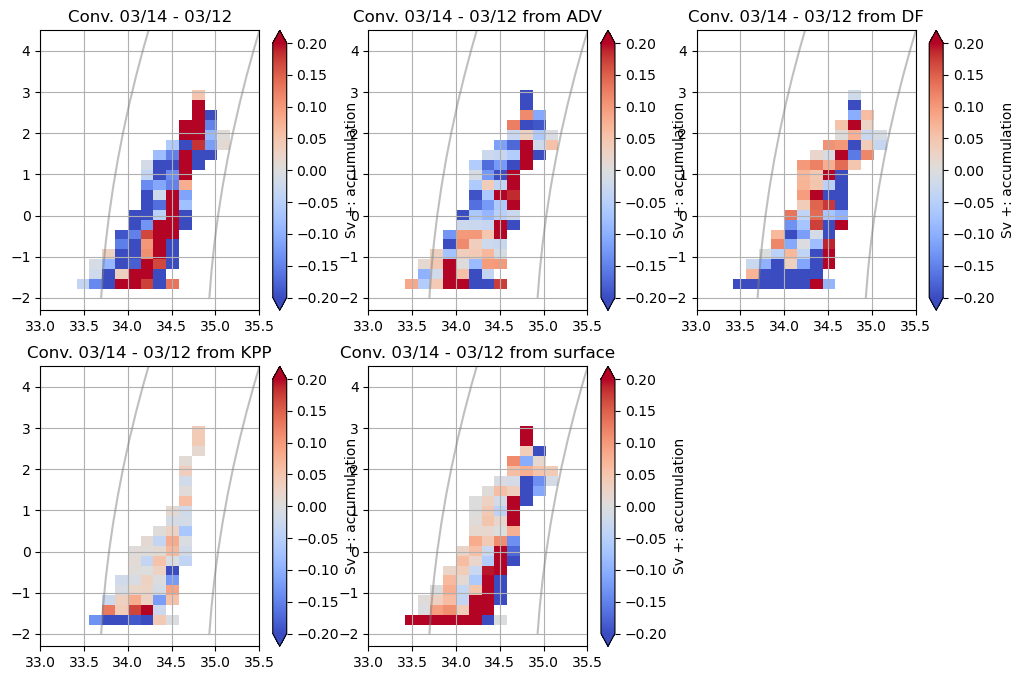

In [62]:
# now try to plot the two tendencies and the anomaly of the two convergences
vlev = 0.2
# First, set up the plot
fig = plt.figure(figsize=(12, 8))

# Total tendency for early years
ax = plt.subplot(231)
U1, V1 = JtermsS_nn[0] - JtermsS_nn_03_07[0], JtermsT_nn[0] - JtermsT_nn_03_07[0]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Set title, limits, and grid
ax.set_title("Conv. "+ timestr)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################

# advection plot
ax = plt.subplot(232)
U1, V1 = JtermsS_nn[1] - JtermsS_nn_03_07[1], JtermsT_nn[1] - JtermsS_nn_03_07[1]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
# U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Set title, limits, and grid
ax.set_title("Conv. "+ timestr + " from ADV")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################
# diffusion plot
ax = plt.subplot(233)
U1, V1 = JtermsS_nn[2] - JtermsS_nn_03_07[2], JtermsT_nn[2] - JtermsS_nn_03_07[2]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
# U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Conv. "+ timestr + " from DF")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################
# KPP plot
ax = plt.subplot(234)
U1, V1 = JtermsS_nn[3] - JtermsS_nn_03_07[3], JtermsT_nn[3] - JtermsS_nn_03_07[3]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
# U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Conv. "+ timestr + " from KPP")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()


# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

####################################################################################
# surface plot
ax = plt.subplot(235)
U1, V1 = JtermsS_nn[4] - JtermsS_nn_03_07[4], JtermsT_nn[4] - JtermsS_nn_03_07[4]
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
# U1, V1 = U1 * alpha, V1 * beta
divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)

# Plot pcolormesh using the divergence for coloring
# Normalize the divergence values for color mapping

# Use pcolormesh to color the background by divergence
cb1 = ax.pcolormesh(Sbin, Tbin, divergence, cmap='coolwarm', vmin=-vlev,vmax=vlev)
plt.colorbar(cb1, ax=ax, label="Sv +: accumulation",extend="both")

# Plot the quiver on top of the divergence background
#q1 = ax.quiver(Sbincent, Tbincent, U1, V1, width=0.005, scale=scale)

# Set title, limits, and grid
ax.set_title("Conv. "+ timestr + " from surface")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.grid()

# Add density contours
cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
cl = ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# plt.savefig(path + "convergence_anomalies_NBarents_march.png",dpi=300)

In [ ]:
# also do a plot of the vectors for the two sets of times